In [1]:
from paddleocr import PaddleOCR,draw_ocr
import cv2
import random
import pytesseract
from PIL import Image, ImageDraw 
from PIL import ImagePath  
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from tensorflow.keras.models import load_model
import json

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
ocr = PaddleOCR(use_angle_cls=True, lang='en') 


Namespace(cls_batch_num=30, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\GNG/.paddleocr/2.0/cls', cls_thresh=0.9, det=True, det_algorithm='DB', det_db_box_thresh=0.5, det_db_thresh=0.3, det_db_unclip_ratio=2.0, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\GNG/.paddleocr/2.0/det', drop_score=0.5, enable_mkldnn=False, gpu_mem=8000, image_dir='', ir_optim=True, label_list=['0', '180'], lang='en', max_text_length=25, rec=True, rec_algorithm='CRNN', rec_batch_num=30, rec_char_dict_path='./ppocr/utils/dict/en_dict.txt', rec_char_type='ch', rec_image_shape='3, 32, 320', rec_model_dir='C:\\Users\\GNG/.paddleocr/2.0/rec/en', use_angle_cls=True, use_gpu=True, use_pdserving=False, use_space_char=True, use_tensorrt=False, use_zero_copy_run=False)


# Get the min x and y

We only need ocr of first part of the page. So we are going to take the min x and y on the image detected that will be most probably the name of in the card than we will try to crop it slightly before the first page ends. 

In [2]:
def get_boxes(p_ocr_result):
    '''
    Description:
        This fucntion use paddle ocr for text detection after detecting text it will take only
        the fields that we need.
        
    Abberivation: 
        p_ocr_result : Paddle ocr result
        x_point      : x points of the polygon
        
    
    Input:
        p_ocr_result(dict) : Takes paddle ocr results as input
        
    Output:
        first_eight_bbox (list) : List of first eight boxes i.e important
        
    '''
    # Get x_points from the results
    x_points = [polygon[0][0] for polygon in p_ocr_result]
    # Sort according to the minimum x point values and than sort again for minimum y value
    first_eight_bbox= sorted(sorted(p_ocr_result, key = lambda x: x[0][0][0]), key = lambda x: x[1])
    # Getting the above three boxes
    top_three_bbox= sorted(p_ocr_result, key = lambda x: x[0][0][1])
    # extending both of the above lists
    first_eight_bbox.extend(top_three_bbox)
    return first_eight_bbox


# Crop Fields
 to pass again to OCR for Better accuracy 

In [3]:
def get_ocr(PIL_Image):
    '''
    Description:
        We are using tesseract to predict text from the image.
        
    Input:
        PIL_IMAGE (PIL): Image
        
    Output:
        text (str) : Text on the image
    '''
    # Setting mode of the tesseract
    custom_oem_psm_config = r'--oem 3 --psm 6'
    # Passing image to the tesseract to get text
    text = pytesseract.image_to_string(PIL_Image, lang='eng+thai', config=custom_oem_psm_config)
    return text



MODEL_PATH = "models/model.hdf5"
MODEL      = load_model(MODEL_PATH)
def check_orientation(PIL_IMAGE):
    '''
    Description:
        We are using model to get the orientation of the image so that we can rotate image at angle 0 
        and get the required results
    
    '''
    global MODEL
    # Loading Model


    # Inference variables
    LABELS     = [0,90,180, 270]
    # preprocessing
    np_array = np.expand_dims(np.asarray(PIL_IMAGE.resize((224,224))), axis = 0)
    # Prediction
    prediction = MODEL.predict(np_array)
    print([str(i) for i in prediction[0]])
    prediction = np.argmax(prediction[0])
    print(prediction)
    plt.imshow(PIL_IMAGE)
    plt.show()
    
    return  LABELS[prediction]

def get_text(img_path, first_eight_bbox):
    '''
    Description:
        This function get the text from the image by using other fucntions.
        
    Input:
        img_path           (str)  :  path of the image
        first_eight_bbox   (dict) : First eight necessary boxes from which we need text
     
    output:
        first_eight_bbox   (dict) : returns dict with the text
    '''
    # Reading Image by PIL
    full_img = Image.open(img_path)
    # Process only first eight boxes
    for i in first_eight_bbox:
        # Cropping
        im1 = full_img.crop((i[0][0][0], i[0][0][1], i[0][2][0],i[0][2][1]))
        # Converting to np array for further open cv processing
        img = np.asarray(im1)
        # Applyinmg bilitreal filter                
        img = cv2.bilateralFilter(img, 9,20, 20)
        # Extracting Text from the image
        i[1] = get_ocr(img)

    return first_eight_bbox
    

# Plot OCR

['1.0', '9.1165336e-17', '1.1901639e-12', '1.8795395e-12']
0


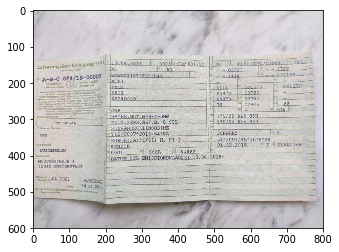

[2021/03/12 00:37:49] root INFO: dt_boxes num : 58, elapse : 0.5146241188049316
[2021/03/12 00:37:50] root INFO: cls num  : 58, elapse : 0.6423375606536865
[2021/03/12 00:37:52] root INFO: rec_res num  : 58, elapse : 1.995934247970581
['1.0', '6.1245185e-18', '1.0900247e-12', '1.8379788e-13']
0


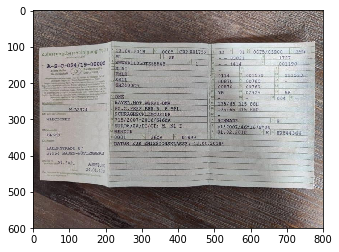

[2021/03/12 00:38:01] root INFO: dt_boxes num : 57, elapse : 0.42901182174682617
[2021/03/12 00:38:01] root INFO: cls num  : 57, elapse : 0.5824687480926514
[2021/03/12 00:38:03] root INFO: rec_res num  : 57, elapse : 1.7155146598815918


In [ ]:
def get_text_from_images(image_path ,save_path = ''):
    '''
    Description:
        Just pass list of images to this fuction it will get text from the images and save on the path you
        pass to the function.
        
    Input:
        images_list  (list) : List of the images
        save_path    (str)  : Path where you want to save the results
    '''
    images_list = glob.glob(image_path)
    assert len(images_list) != 0 , "No Images found"
    for img_path in  images_list:   
        try:
            # Reading image
            img      = Image.open(img_path).convert("RGB")
            rotation = check_orientation(img)
            img      = img.rotate(rotation, expand = True)
            img.save(img_path)

            # Getting ocr
            result               = ocr.ocr(img_path, cls=True)
            first_eight_bbox     = get_boxes(result)
            first_eight_bbox     = get_text(img_path, first_eight_bbox)

            # Plotting image
            img1 = ImageDraw.Draw(img)   
            for polygon in first_eight_bbox:
                text    = "".join([i for i in polygon[1] if i.isalpha() or i.isdigit() or i == ' '])
                xy      = [tuple(i) for i in polygon[0]]
                img1.polygon(xy, outline ="blue") 
                img1.text(xy[0], text)
            
            # saving preprocessed Image
            if save_path != '':
                # saving Image
                os.system("mkdir '{}'".format(save_path))
                image_name = img_path.rsplit("\\",1)[1]
                temp_save  = "{}Processed{}".format(save_path, image_name) 
                img.save(temp_save)
                
                # Saving results
                with open(temp_save+".txt", 'w') as outfile:
                    json.dump(first_eight_bbox, outfile)
                
            
        except StopIteration as e:
            print("Exception occurred ", e)

image_path  = "images\\*.*g"
save_path   = "images/output/"

get_text_from_images(image_path ,save_path)

# Test Rotated Images

Rotate image if needed

In [ ]:

img_path = "images\\11.jpg"
img = Image.open(img_path)
img = img.rotate(180, expand=1)
img.save(img_path)
plt.imshow(img)
plt.show()